In [96]:
import os
from os.path import join as oj
import sys
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
from data_load_preprocess import data


import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from copy import deepcopy
import pickle as pkl
import pandas as pd

from params import p
from fit import fit
# from fit_mse import fit_mse

# from fit_ce import fit_ce


plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [224]:
def dummy_fit(p, non_lin=relu, optim=torch.optim.SGD):
    # set random seed        
    np.random.seed(p.seed) 
    torch.manual_seed(p.seed)

    # generate data
    X, y, W, b, W2 = generate_2_layer_data(
                          d=p.d_in, dist_x=p.dist_x, dist_w=p.dist_w, 
                          num_data=p.N, num_hidden=p.true_hidden1,
                          use_bias=p.use_bias, dist_b=p.dist_b, non_lin=non_lin)
    dset = data.dset(X, y)
    print(non_lin)
    # make model
    if non_lin==tanh:
        model = torch.nn.Sequential(
            torch.nn.Linear(p.d_in, p.fit_hidden1),
            torch.nn.Tanh(),
            torch.nn.Linear(p.fit_hidden1, p.d_out, bias=False),
        )
    else:
        model = torch.nn.Sequential(
            torch.nn.Linear(p.d_in, p.fit_hidden1),
            torch.nn.ReLU(),
            torch.nn.Linear(p.fit_hidden1, p.d_out, bias=False),
        )
    
    # freeze second layer weights
    child_counter = 0
    for child in model.children():
        if child_counter == 2:
            for i, param in enumerate(child.parameters()):
                param.requires_grad = False
                if i==0:
                    param.data = torch.from_numpy(np.ones((1,p.fit_hidden1))/p.fit_hidden1).float()
        child_counter += 1

     # set up optimization
    optimizer = optim(filter(lambda a: a.requires_grad, model.parameters()), lr=p.lr) 
    # only optimize ridge (otherwise use model.parameters())
    scheduler = StepLR(optimizer, step_size=p.step_size_optimizer, gamma=p.gamma_optimizer)
    loss_fn = torch.nn.MSELoss(size_average=False)
#     dataloader = DataLoader(dset, batch_size=p.batch_size, shuffle=True)

    # to record
    weights = {}
    losses = np.zeros(p.num_iters)

    X_torch = torch.from_numpy(X).float()
    y_torch = torch.from_numpy(y).float()
    
    # fit
    # batch gd
    for it in tqdm(range(p.num_iters)):
        y_pred = model(Variable(X_torch, requires_grad=True)) # predict
        y_pred = torch.reshape(y_pred, (-1,))
        loss = loss_fn(y_pred, y_torch) # calculate loss
        optimizer.zero_grad() # zero the gradients
        loss.backward() # backward pass
        optimizer.step() # update weights
        scheduler.step() # step for incrementing optimizer

        # output
        if it % 1 == 0 or it==p.num_iters-1:
            weight_dict = {x[0]:x[1].data.numpy() for x in model.named_parameters()}
            weights[it] = deepcopy(weight_dict)
        losses[it] = loss.data.item()

    # save
    if not os.path.exists(p.out_dir):  # delete the features if they already exist
        os.makedirs(p.out_dir)
    params = p._dict(p)
    
    # predict things
    X_train = X
    y_train = y
    pred_train = model(Variable(torch.from_numpy(X_train).float(), requires_grad=True)).data.numpy() # predict

    if p.d_in > 1:
        X_test = X_train
    else:
        X_test = np.linspace(np.min(X), np.max(X), 1000, dtype=np.float32)
        X_test = X_test.reshape(X_test.shape[0], 1)
    pred_test = model(Variable(torch.from_numpy(X_test).float(), requires_grad=True)).data.numpy() #
    
    results = {'true_weights': [W, b, W2, p.use_bias],
               'weights': weights, 'losses': losses,
               'min_loss': np.min(losses), 
               'model': model, 
               'X_train': X_train, 'y_train':y_train, 'pred_train': pred_train, 
               'X_test': X_test, 'pred_test':pred_test}
    results_combined = {**params, **results}
    return results_combined

In [248]:
def plot_results(pr, st=None):
    print(pr['model'])

    a, b = 1, 3
    plt.figure(figsize=[3.4*b, 3*a])
    plt.subplot(131)
    plt.semilogy(pr['losses'])
    plt.title('Loss')
    plt.subplot(132)
    plt.scatter(pr['y_train'], pr['pred_train'])
    plt.title('Train (x) vs Prediction (y)')
    plt.subplot(133)
    plt.hist([pr['X_train'][:, 0], pr['X_train'][:, 1]])
    plt.title('X histogram')
    plt.suptitle(st)
    plt.show()

    idxs = np.sort(np.array(list(pr['weights'].keys())))
    a, b = 2, 4
    plt.figure(figsize=[3.4*b, 3*a])
    plt.subplot(a, b, 1)
    scatter_matrix(pr['true_weights'][0])
    plt.title('True')
    for i, idx in enumerate(idxs[:70:10]):
        plt.subplot(a, b, i+2)
        plt.title('iter=%d'%(idx))
        scatter_matrix(pr['weights'][idx]['0.weight'])
    plt.suptitle('2 Means')
    plt.show()

    plt.figure(figsize=[3.4*b, 3*a])
    for i, idx in enumerate(idxs[100::int((len(idxs)-100)/7)]):
        plt.subplot(a, b, i+1)
        plt.title('iter=%d'%(idx))
        scatter_matrix(pr['weights'][idx]['0.weight'])
#     plt.suptitle('2 Means')
    plt.show()

In [194]:
from params2 import p2

# Laplace Noise

In [163]:
results2d_laplace_large_var_x = dummy_fit(p2, non_lin=relu)

  0%|          | 91/20000 [00:00<00:22, 902.10it/s]

<function relu at 0x7f4b5eb20268>


100%|██████████| 20000/20000 [00:22<00:00, 894.65it/s]


Sequential(
  (0): Linear(in_features=2, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=False)
)


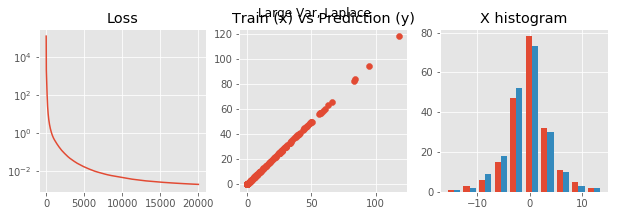

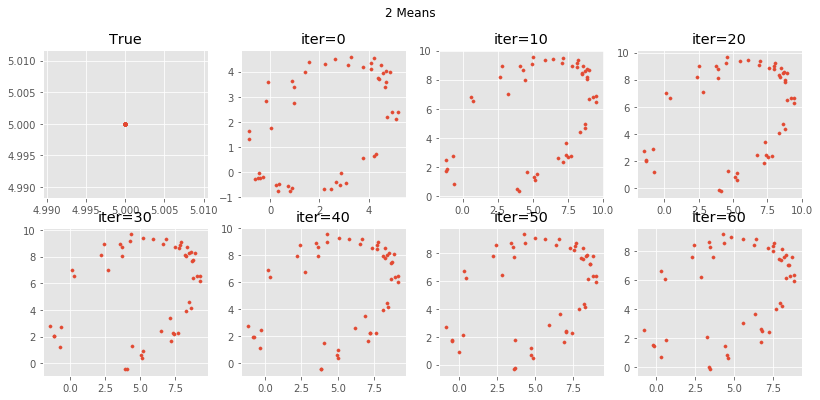

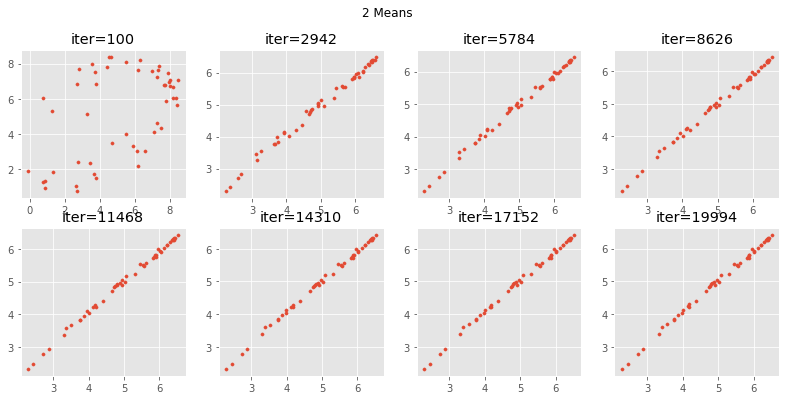

In [187]:
plot_results(results2d_laplace_large_var_x, 'Large Var, Laplace')

In [198]:
from params2 import p2
results2d_laplace_mog = dummy_fit(p2, non_lin=relu)

  0%|          | 92/20000 [00:00<00:21, 914.21it/s]

<function relu at 0x7f4b5eb20268>


100%|██████████| 20000/20000 [00:22<00:00, 890.76it/s]


Sequential(
  (0): Linear(in_features=2, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=False)
)


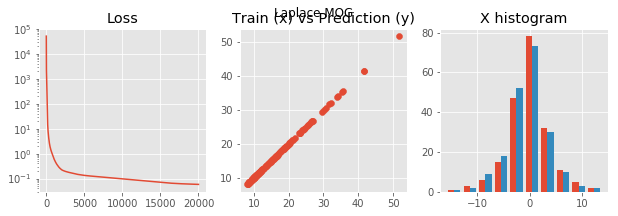

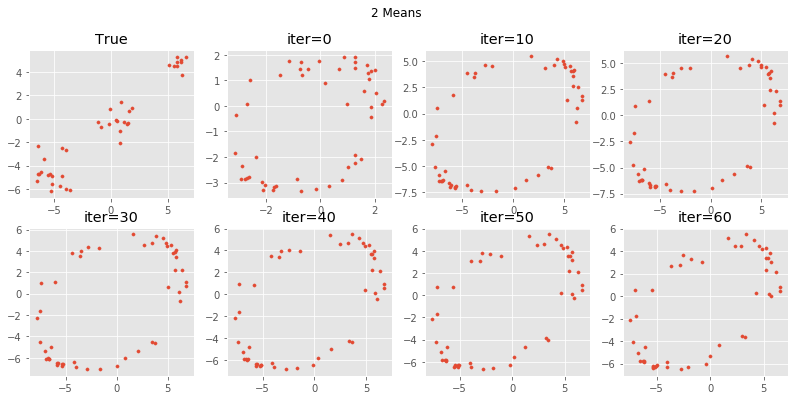

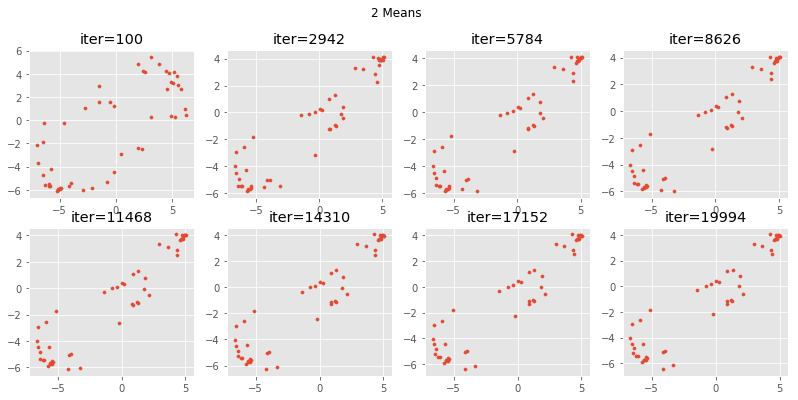

In [199]:
plot_results(results2d_laplace_mog, 'Laplace MOG')

In [201]:
from params2 import p2
results2d_laplace_mog_small_var = dummy_fit(p2, non_lin=relu)

  0%|          | 92/20000 [00:00<00:21, 914.18it/s]

<function relu at 0x7f4b5eb20268>


100%|██████████| 20000/20000 [00:22<00:00, 895.34it/s]


Sequential(
  (0): Linear(in_features=2, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=False)
)


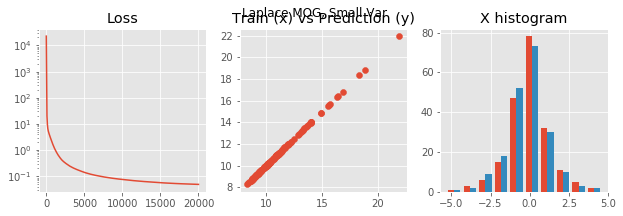

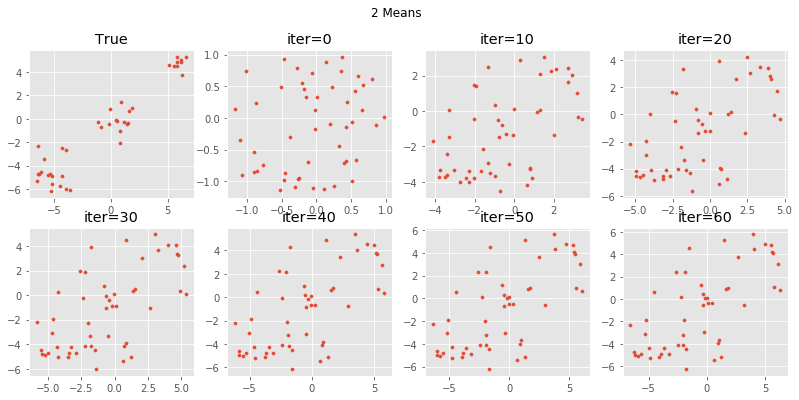

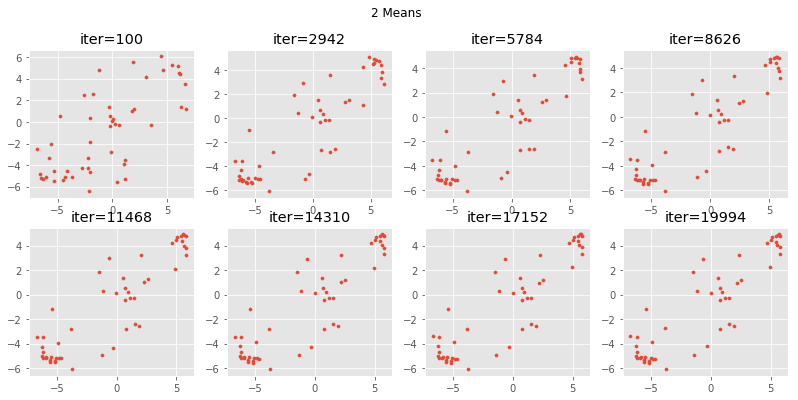

In [202]:
plot_results(results2d_laplace_mog_small_var, 'Laplace MOG, Small Var')

# Normal Case

In [171]:
results2d_normal_small_sd_x = dummy_fit(p2)

  0%|          | 90/20000 [00:00<00:22, 898.25it/s]

<function relu at 0x7f4b5eb20268>


100%|██████████| 20000/20000 [00:22<00:00, 889.92it/s]


Sequential(
  (0): Linear(in_features=2, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=False)
)


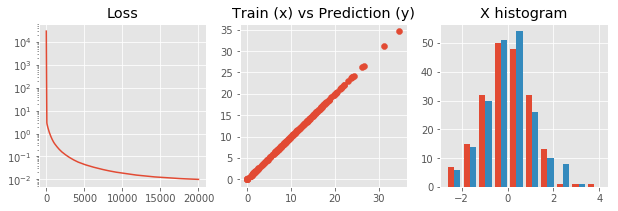

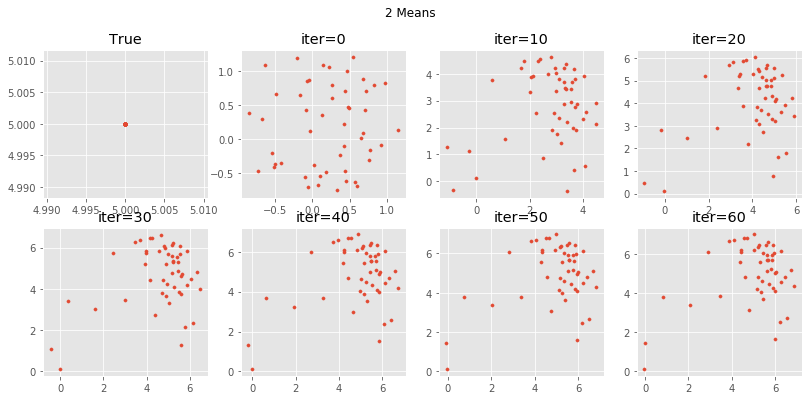

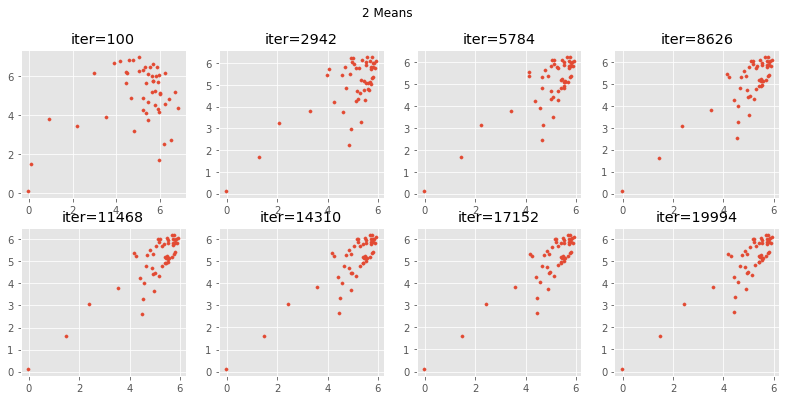

In [178]:
plot_results(results2d_normal_small_sd_x)

In [189]:
from params2 import p2

In [190]:
results2d_normal_large_var_x = dummy_fit(p2)

  0%|          | 87/20000 [00:00<00:22, 869.30it/s]

<function relu at 0x7f4b5eb20268>


100%|██████████| 20000/20000 [00:24<00:00, 826.77it/s]


Sequential(
  (0): Linear(in_features=2, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=False)
)


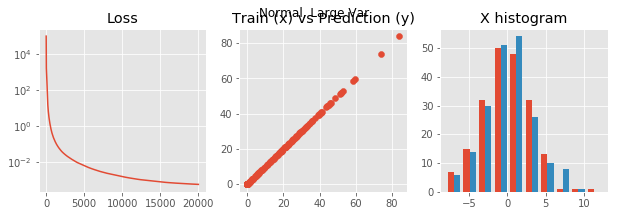

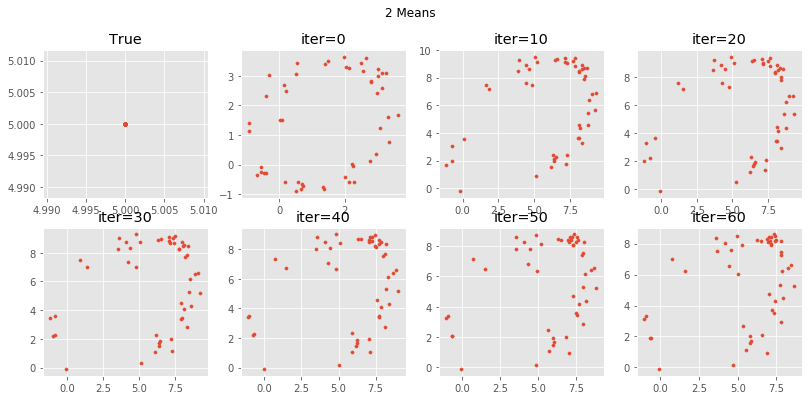

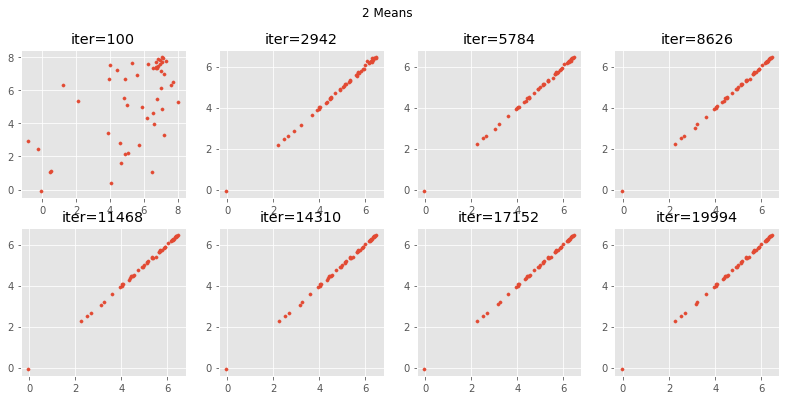

In [191]:
plot_results(results2d_normal_large_var_x, 'Normal, Large Var')

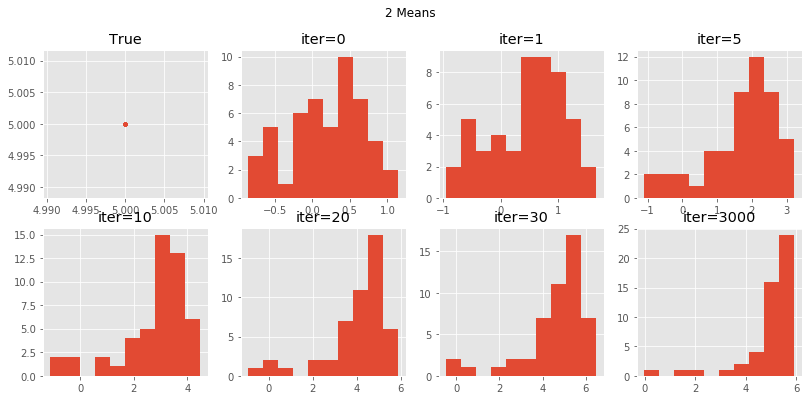

In [236]:
plt.figure(figsize=[3.4*b, 3*a])
plt.subplot(a, b, 1)
scatter_matrix(pr['true_weights'][0])
plt.title('True')
for i, idx in enumerate(idxs[[0, 1, 5, 10, 20, 30, 3000]]):
# for i, idx in enumerate(idxs[::int(len(idxs)/6)]):
    plt.subplot(a, b, i+2)
    plt.title('iter=%d'%(idx))
    plt.hist([pr['weights'][idx]['0.weight'][:, 0]])
plt.suptitle('2 Means')
plt.show()


# 6dm

In [206]:
from params2 import p2
results6d = dummy_fit(p2, relu)

  0%|          | 81/20000 [00:00<00:24, 809.61it/s]

<function relu at 0x7f4b5eb20268>


100%|██████████| 20000/20000 [00:24<00:00, 816.36it/s]


In [237]:
# plot_results(results6d)

# Adam vs SGD

In [231]:
from params2 import p2


  0%|          | 32/30000 [00:00<01:33, 319.95it/s]

<function relu at 0x7f4b5eb20268>


100%|██████████| 30000/30000 [01:26<00:00, 348.27it/s]


Sequential(
  (0): Linear(in_features=2, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=1, bias=False)
)


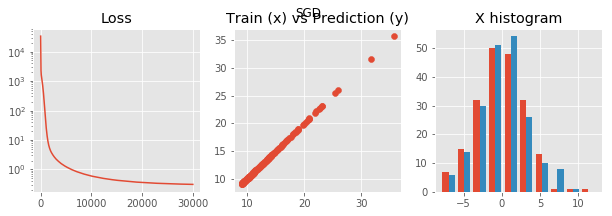

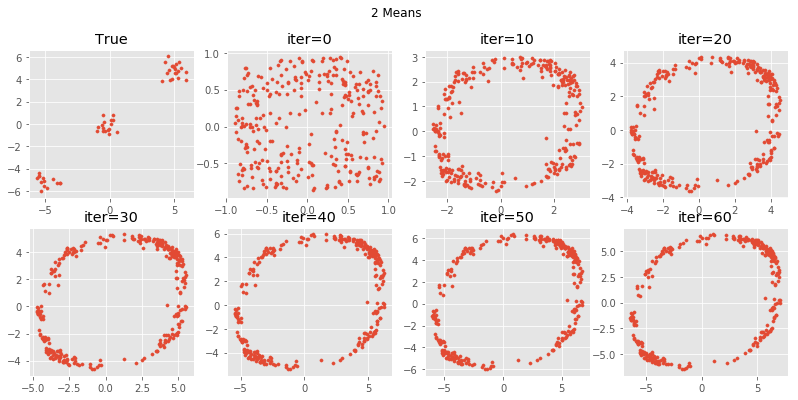

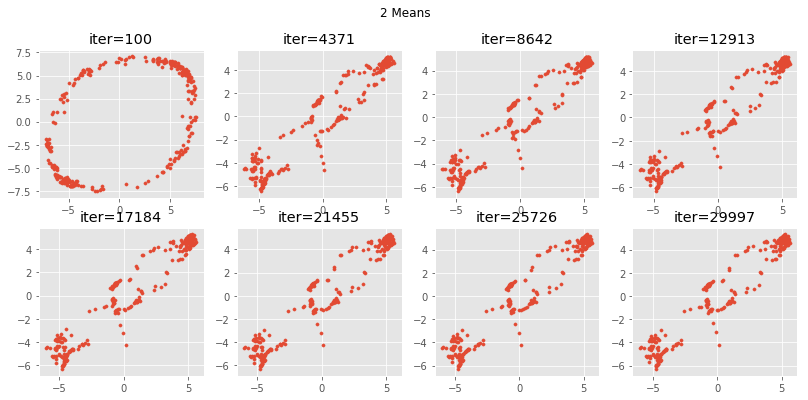

In [232]:
results_2d_sgd = dummy_fit(p2, relu)
plot_results(results_2d_sgd, 'SGD')

In [249]:
results_2d_adam = dummy_fit(p2, relu, torch.optim.Adam)

Sequential(
  (0): Linear(in_features=2, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=1, bias=False)
)


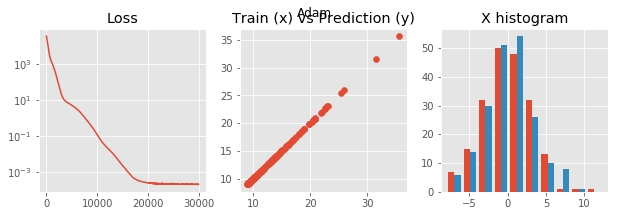

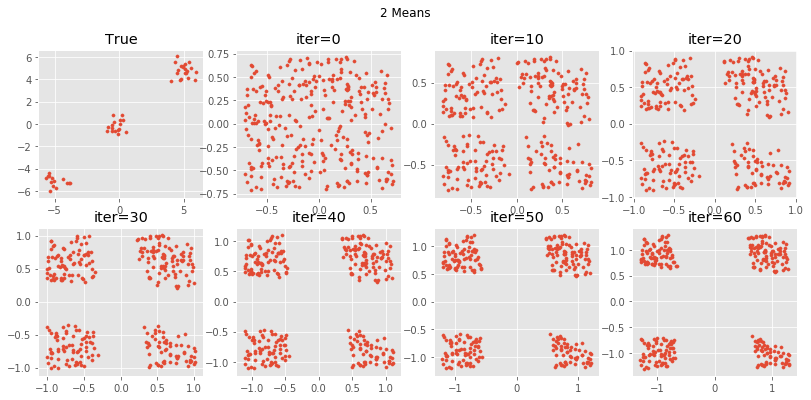

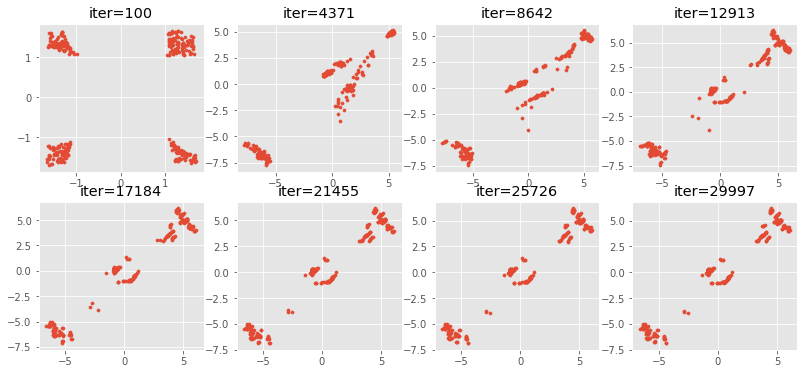

In [250]:
plot_results(results_2d_adam, 'Adam')

In [251]:
# pr = results_2d_sgd
# idxs = np.sort(np.array(list(pr['weights'].keys())))
# a, b = 2, 4
# plt.figure(figsize=[3.4*b, 3*a])
# plt.subplot(a, b, 1)
# scatter_matrix(pr['true_weights'][0])
# plt.title('True')
# for i, idx in enumerate(idxs[:35:5]):
#     plt.subplot(a, b, i+2)
#     plt.title('iter=%d'%(idx))
#     scatter_matrix(pr['weights'][idx]['0.weight'])
# plt.suptitle('3 Means SGD')
# plt.show()

# pr = results_2d_adam
# idxs = np.sort(np.array(list(pr['weights'].keys())))
# a, b = 2, 4
# plt.figure(figsize=[3.4*b, 3*a])
# plt.subplot(a, b, 1)
# scatter_matrix(pr['true_weights'][0])
# plt.title('True')
# for i, idx in enumerate(idxs[:35:5]):
#     plt.subplot(a, b, i+2)
#     plt.title('iter=%d'%(idx))
#     scatter_matrix(pr['weights'][idx]['0.weight'])
# plt.suptitle('3 Means ADAM')
# plt.show()

# 3 mixtures

In [305]:
# tmp = KMeans(n_clusters=3, random_state=0).fit(results2d['true_weights'][0])
# tmp.cluster_centers_

array([[ 2.03696923,  2.02921088],
       [-5.01333872, -5.04760716],
       [ 4.99161499,  5.02191849]])

## some plots with centers

In [213]:
def scatter_matrix(M):
    n, d = M.shape
#     if d >2:
#         M = M.T
    plt.scatter(M[:, 0], M[:, 1], s=10.)

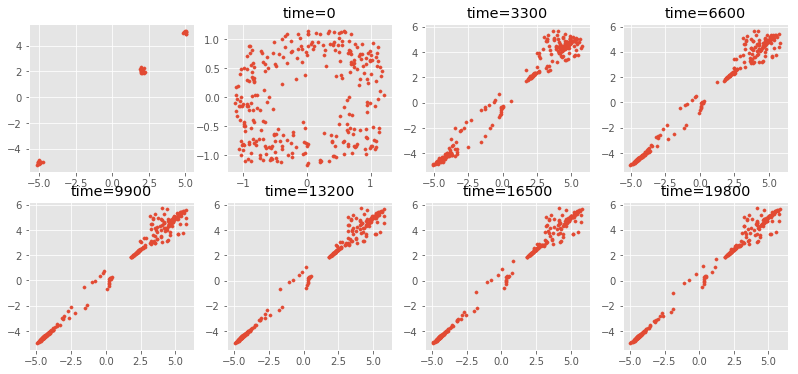

In [357]:
idxs = np.sort(np.array(list(results2d['weights'].keys())))
a, b = 2, 4
plt.figure(figsize=[3.4*b, 3*a])
plt.subplot(a, b, 1)
scatter_matrix(results2d['true_weights'][0])
for i, idx in enumerate(idxs[::int(len(idxs)/6)]):
    plt.subplot(a, b, i+2)
    plt.title('time=%d'%(idx))
    scatter_matrix(results2d['weights'][idx]['0.weight'])
plt.show()

# One d simulations

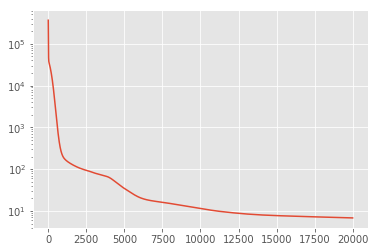

In [203]:
y_true = compute_2_layer(X=results['X_test'], W=results['true_weights'][0], 
                b=results['true_weights'][1], W2=results['true_weights'][2], 
                use_bias=results['true_weights'][3])
plt.semilogy(results['losses'])
plt.show()

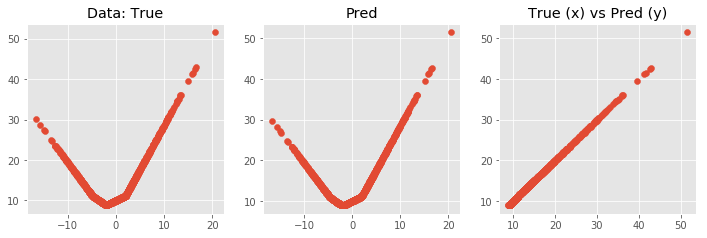

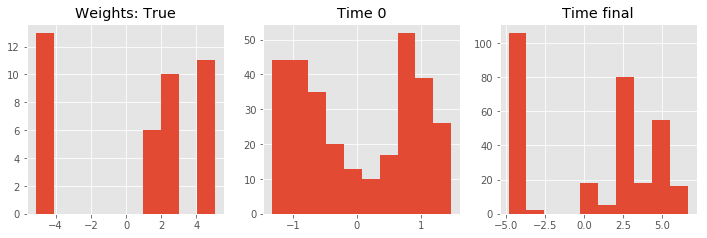

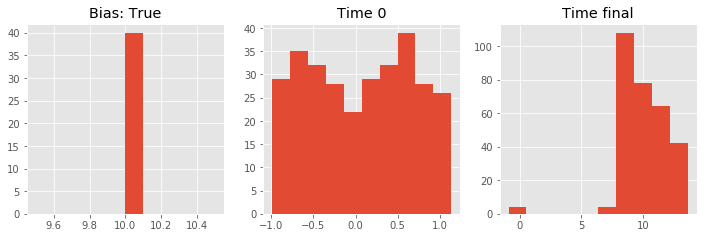

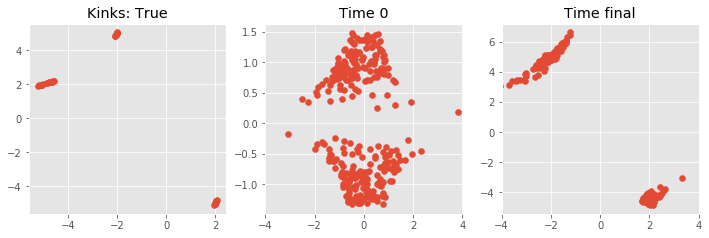

In [204]:
minidx = 0
maxidx = max(results['weights'].keys())

plt.figure(figsize=[12, 3.5])
plt.subplot(131)
plt.scatter(results['X_train'], results['y_train'])
plt.title('Data: True')
plt.subplot(132)
plt.scatter(results['X_train'], results['pred_train'])
plt.title('Pred')
plt.subplot(133)
plt.scatter(results['y_train'], results['pred_train'])
plt.title('True (x) vs Pred (y)')
plt.show()

plt.figure(figsize=[12, 3.5])
plt.subplot(131)
plt.hist(results['true_weights'][0])
plt.title('Weights: True')
plt.subplot(132)
plt.hist(results['weights'][minidx]['0.weight'])
plt.title('Time 0')
plt.subplot(133)
plt.hist(results['weights'][maxidx]['0.weight'])
plt.title('Time final')
plt.show()

plt.figure(figsize=[12, 3.5])
plt.subplot(131)
plt.hist(results['true_weights'][1])
plt.title('Bias: True')
plt.subplot(132)
plt.hist(results['weights'][minidx]['0.bias'])
plt.title('Time 0')
plt.subplot(133)
plt.hist(results['weights'][maxidx]['0.bias'])
plt.title('Time final')
plt.show()

xlims = [-4, 4]
plt.figure(figsize=[12, 3.5])
plt.subplot(131)
plt.scatter(-results['true_weights'][1]/results['true_weights'][0], 
            results['true_weights'][0])
plt.title('Kinks: True')
plt.subplot(132)
plt.scatter(-results['weights'][minidx]['0.bias']/results['weights'][minidx]['0.weight'].flatten(), 
            results['weights'][minidx]['0.weight'].flatten())
plt.xlim(xlims)
plt.title('Time 0')
plt.subplot(133)
plt.scatter(-results['weights'][maxidx]['0.bias']/results['weights'][maxidx]['0.weight'].flatten(), 
            results['weights'][maxidx]['0.weight'].flatten())
plt.xlim(xlims)
plt.title('Time final')
plt.show()




# Analyzing the clusters

In [215]:
def rearrange_cluster(cluster, target):
    # rearrange to find the permuted centers 
    
    k, d = np.shape(cluster)
    ds = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            ds[i, j] = np.linalg.norm(cluster[i, :]-target[j, :])
    sorted_cluster = np.zeros_like(cluster)
    for i in range(k):
        sorted_cluster[i, :] = cluster[np.argmin(ds[:, i]), :]
    
    return sorted_cluster

In [216]:
from sklearn.cluster import KMeans

In [269]:
num_clusters = len(p2.dist_w['params']['weights'])
idxs = np.sort(np.asarray(list(results['weights'].keys())))
centers = np.zeros((num_clusters, len(idxs)))
true_centers = p2.dist_w['params']['means']

In [270]:
for i, idx in enumerate(idxs):
    _, ws = return_kinks(results, idx)
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(ws.reshape(-1, 1))
    centers[:, i] = rearrange_cluster(kmeans.cluster_centers_, true_centers).flatten()


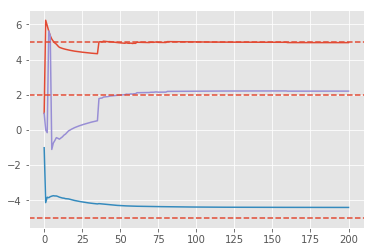

In [271]:
for i in range(num_clusters):
    plt.plot(centers[i,:])

for i in range(num_clusters):
    plt.axhline(true_centers[i, 0], linestyle='--')

plt.show()

In [205]:
def return_kinks(res, idx):
    num = -res['weights'][idx]['0.bias']
    den = res['weights'][idx]['0.weight'].flatten()
    return num/den, den

In [100]:
# Relu non-linearity
def relu(a):
    return a * (a>0)

def tanh(a):
    return np.tanh(a)

# generate Laplace data
def generate_laplace(d, params, N):
    loc = np.asarray(params['loc'])
    scale = params['scale']
    return np.random.laplace(loc=loc, scale=scale, size=[N, d])
    
# generate Gaussian data
def generate_normal(d, params, N):
    # mean is a np array even if 1d.
    mean = np.asarray(params['mean'])
    sd = params['sd']
 
    return np.random.multivariate_normal(mean, np.eye(d) * np.power(sd, 2), N)

# generate Mixture of Gaussian data
def generate_mog(d, params, N):
    # mean is a np array of arrays
    
    means = params['means']
    weights = params['weights']
    weights /= np.sum(weights)
    sds = params['sds']
    
    idxs = np.random.choice(a=np.arange(0, len(weights)), size=N, p=weights)
    data = np.zeros((N, d))
    for i in range(N):
        mean = means[idxs[i]]
        sd = sds[idxs[i]]
        data[i, :] = np.random.multivariate_normal(mean, np.eye(d) * np.power(sd, 2))
    
    return data

# generate n random points in d dimensions based on the dictionary which has all parameters
def generate_data_from_dict(dparams, d, n):
    assert(len(dparams['params']) == dist_num_param_dict[dparams['name']])
    return dist_gen_dict[dparams['name']](d, dparams['params'], n)

def compute_2_layer(X, W, b, W2, non_lin, use_bias=False):
    if use_bias:
        layer_1 = X.dot(W.T) + b.flatten()
    else:
        layer_1 = X.dot(W.T)
    
    nlayer_1 = non_lin(layer_1)
    y = nlayer_1.dot(W2)
    
    return y

# generate data from teacher network
def generate_2_layer_data(d, dist_x, dist_w, 
                          num_data, num_hidden, 
                          use_bias=False, dist_b=None,
                          non_lin=relu):

    X = generate_data_from_dict(dparams=dist_x, d=d, n=num_data)
    W = generate_data_from_dict(dparams=dist_w, d=d, n=num_hidden)
    
    if use_bias:
        b = generate_data_from_dict(dparams=dist_b, d=1, n=num_hidden)
    else:
        b = None

    # layer 2 Fixed
    W2 = np.ones(num_hidden)/num_hidden    

    # compute y
    y = compute_2_layer(X, W, b, W2, non_lin, use_bias)

    # reshape W2
    W2 = np.reshape(W2, (-1, 1))
    
    return X, y, W, b, W2


# Dictionary for various mappings across distributions

# ***** Update These Dictionaries for New Distributions *********

# distribution generation function dictionary
dist_gen_dict = {"normal":  generate_normal,
            "mog":  generate_mog,
            "laplace": generate_laplace}

# distribution generation function number of parameters dictionary
dist_num_param_dict = {"normal":  2,
            "mog":  3,
            "laplace": 2}



## fit

In [8]:
results = fit(p)

  0%|          | 0/20000 [00:00<?, ?it/s]/usr/local/linux/anaconda3/lib/python3.5/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 20000/20000 [00:23<00:00, 858.10it/s]


# analyze results

In [203]:
# plot loss and norms
plt.figure(figsize=(14, 3))
plt.subplot(131)
plt.semilogx(results['losses'])
plt.title('loss')

plt.subplot(132)
plt.plot(results['accs'])
plt.title('acc')

plt.subplot(133)
plt.plot(results['norms'][:, 0] - results['norms'][:, 1])
plt.title('w2 norm - w1 norm (should be constant)')
plt.show()

# plotting preds

In [204]:
model = results['model']
X, y, y_plot = data.generate_gaussian_data(results['N'], means=results['means'], sds=results['sds'], labs=results['labs'])

# plot predictions
plt.figure(figsize=(5, 5), dpi=150)

preds = model(Variable(torch.from_numpy(X), requires_grad=True)).data.numpy() # predict
# plt.scatter(X, np.argmax(preds, axis=1), label='pred top class')
X_grid = np.linspace(np.min(X), np.max(X), 1000, dtype=np.float32)
X_grid = X_grid.reshape(X_grid.shape[0], 1)
preds_grid = model(Variable(torch.from_numpy(X_grid), requires_grad=True)).data.numpy() # predict

plt.scatter(X, y_plot, label='data labels', alpha=0.5, marker='x')
plt.scatter(X_grid, preds_grid[:, 1], label='pred probability of class 1', color='orange') # note other class is 1 - this
# plt.scatter(X_grid, preds_grid[:, 0], label='pred probability of class 0', color='green') # note other class is 1 - this
plt.plot([-1000, 1000], [0.5, 0.5], '--')
plt.xlim([np.min(X), np.max(X)])
plt.legend()
plt.show()